In [11]:
import numpy as np
import torch 
import pandas as pd
import pickle
import time
import sys
import itertools
import pandas as pd


from IPython.display import Image
import matplotlib.pyplot as plt
from tueplots import axes, bundles
import tueplots

plt.rcParams.update({"figure.dpi": 150})

plt.rcParams.update(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
)

In [12]:
from scipy import stats
from scipy.stats import norm
from botorch.models.transforms.input import Warp

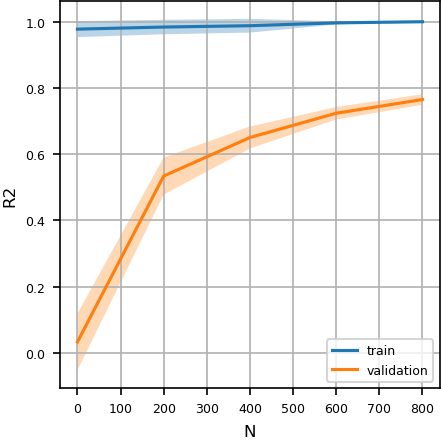

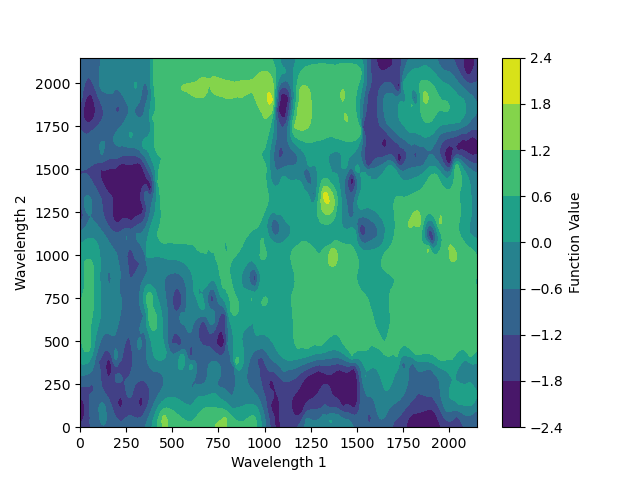

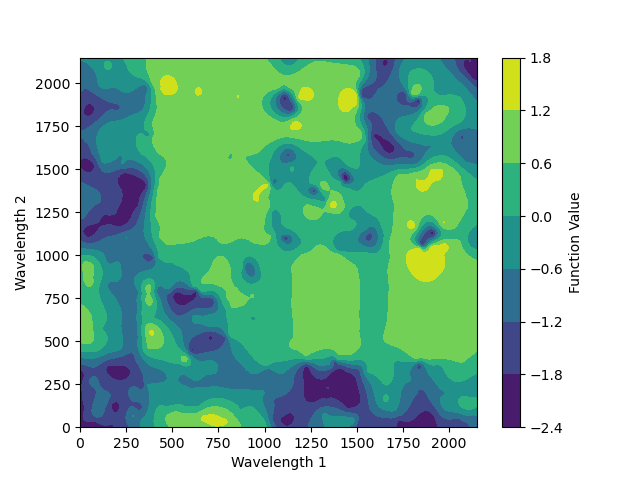

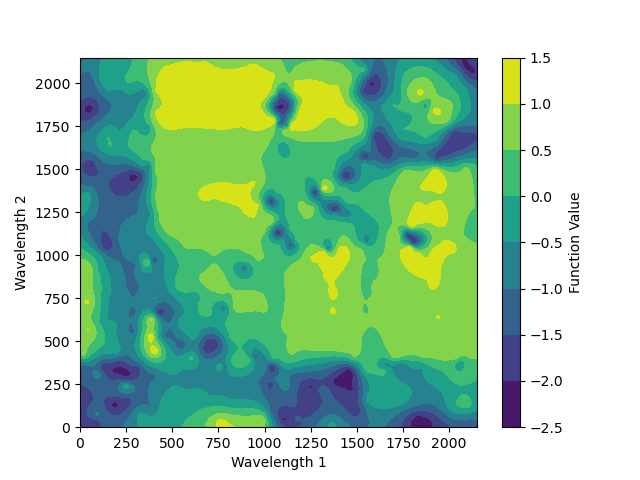

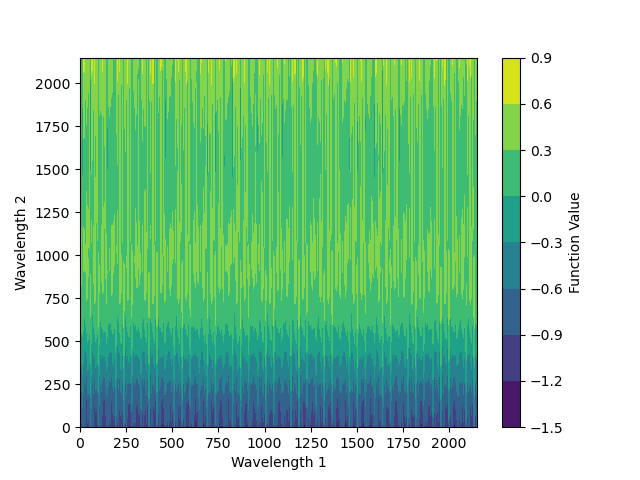

In [78]:
#plotting a learning curve
timestamp = "test"#"20240417-164214"#"gp_fit_log_narea" #change to the run's folder
base_path = f"./output/{timestamp}"
seeds = [1,2,3,4]
trait = "narea"

with plt.rc_context(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)):
    fig, ax = plt.subplots(1,1, figsize=(3,3))

    def getCol(col_name):
        _results = [pd.read_csv(f"{base_path}/gp_{seed}.npy", encoding='utf-8')[col_name] for seed in seeds]
        _results = [np.array(_results[i]) for i in range(0,len(_results))]
        return _results

    n = getCol("n")[0]
    train_loss = getCol("train_loss")
    val_loss = getCol("val_loss")

    def linePlot(ax, _results, label):
        mean, var = np.mean(_results, axis=0), np.std(_results, axis=0)
        ax.plot(n, mean, label=label)
        ax.fill_between(n, mean - var,  mean + var, alpha=0.3)
        return

    linePlot(ax, train_loss, label="train")
    linePlot(ax, val_loss, label="validation")

    ax = ax
    #ax.set_title(f"{timestamp}") 
    #ax.set_title(f"saas gp fit, narea") 
    ax.set_xlabel("N") 
    ax.set_ylabel("R2")
    ax.legend(loc="lower right")
    ax.grid(True)
    #ax.set_ylim(-0.2, 1)
    plt.show()

for seed in seeds:
    display(Image(filename=f"{base_path}/gp_{seed}.png"))

    #Image(filename=f"{base_path}/gp_{seed}.png") 

In [4]:
def getLookup(trait, transform=None):
    path = f"./data/{trait}_coh2.csv"
    lookup = pd.read_csv(path, header=0)

    # Replace nans with zero
    lookup_tensor = torch.tensor(lookup.values, dtype=torch.float64)
    no_nan_lookup = torch.nan_to_num(lookup_tensor)
    no_nan_lookup[no_nan_lookup > 1] = 0
    return no_nan_lookup

#define a lookup function
def lookup(X):
    X_indices = X.long().cpu()
    Y = table[X_indices[:, 0], X_indices[:, 1]].reshape(-1, 1)
    return Y.to(X)

#function to make zeros a small Z
def cleanZeros(data):
    mask = data == 0
    data[mask] = 10e-6
    #zero_values = data[data == 0]
    return data

def stadardize(data):
    mean = data.mean()
    std = data.std()    
    standardized_data = (data - mean) / std
    return standardized_data

In [5]:
#load search space
table = getLookup("narea")
table

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.2898, 0.2913, 0.2911],
        [0.0000, 0.0000, 0.0648,  ..., 0.2707, 0.2727, 0.2728],
        [0.0000, 0.0673, 0.0000,  ..., 0.2809, 0.2826, 0.2826],
        ...,
        [0.2642, 0.2360, 0.2440,  ..., 0.0000, 0.0000, 0.0000],
        [0.2644, 0.2359, 0.2440,  ..., 0.0000, 0.0000, 0.0252],
        [0.2644, 0.2360, 0.2439,  ..., 0.0000, 0.0247, 0.0000]],
       dtype=torch.float64)

/dfs/scratch0/ruhana/miniconda3/envs/genCorSearch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


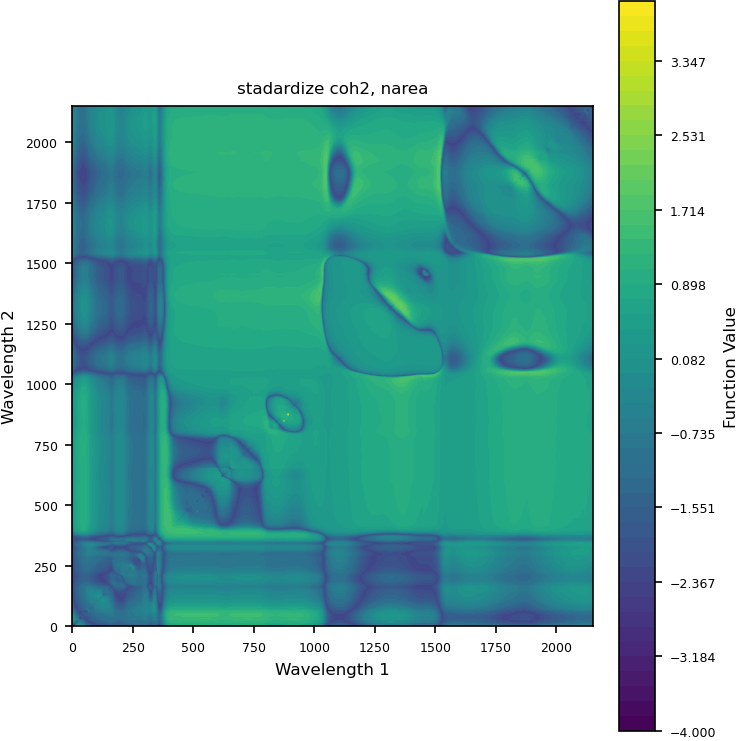

In [6]:
#visualize the search space
# Generate data for the plot
n=500
x1 = torch.linspace(0, 2150, n)
x2 = torch.linspace(0, 2150, n)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

Z = lookup(X)
Z = cleanZeros(Z)
Z_org = stadardize(Z)

# Create a contour plot
#Z = torch.clamp(Z, -4, 4)
plt. figure(figsize=(5,5))
plt.contourf(X1, X2, Z_org.reshape(n, n), cmap='viridis', levels=np.linspace(-4, 4, 50))
cbar = plt.colorbar(label='Function Value')

# Add labels and title
plt.xlabel('Wavelength 1')
plt.ylabel('Wavelength 2')
plt.title("stadardize coh2, narea")

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')
cbar.ax.set_aspect(10, adjustable='box')
plt.show()

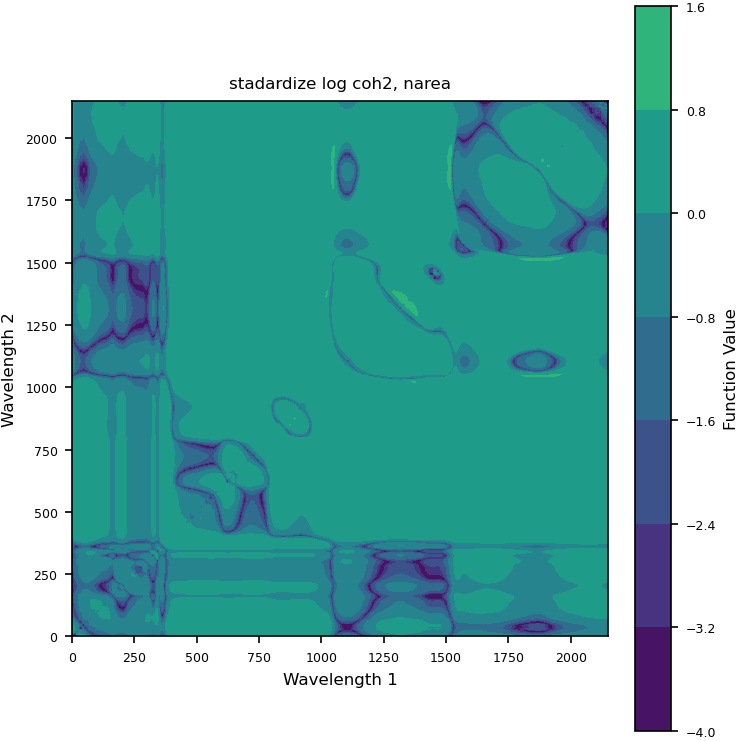

In [7]:
#visualize the search space
# Generate data for the plot
n=500
x1 = torch.linspace(0, 2150, n)
x2 = torch.linspace(0, 2150, n)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

Z = lookup(X)
Z = cleanZeros(Z)
Z = stadardize(torch.log(Z))

#to help with the plotting visuals
Z = torch.clamp(Z, -4, 4)

# Create a contour plot
plt. figure(figsize=(5,5))
plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis', vmin=-4, vmax=4)
cbar = plt.colorbar(label='Function Value')

# Add labels and title
plt.xlabel('Wavelength 1')
plt.ylabel('Wavelength 2')
plt.title("stadardize log coh2, narea")

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')
cbar.ax.set_aspect(10, adjustable='box')
plt.show()

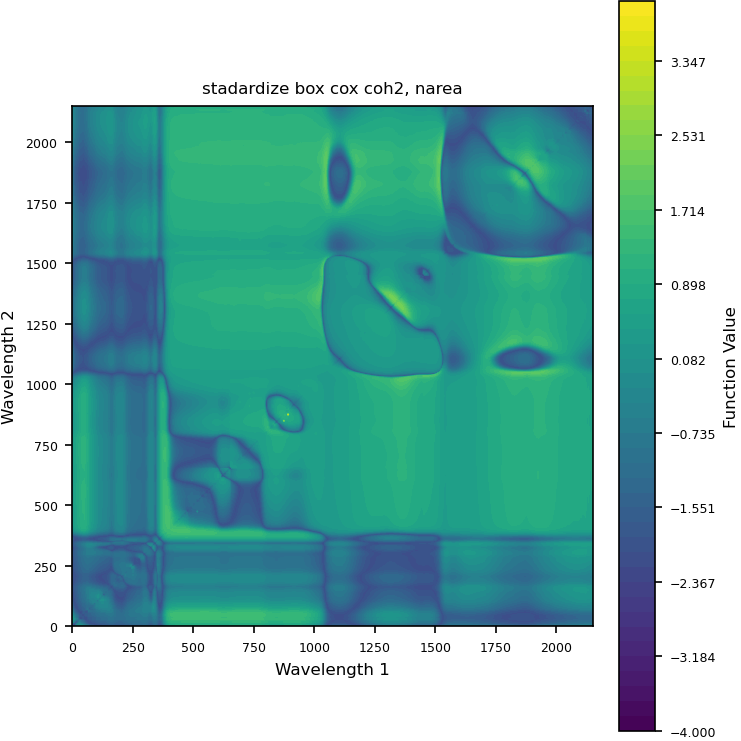

In [8]:
#visualize the search space
# Generate data for the plot
n=500
x1 = torch.linspace(0, 2150, n)
x2 = torch.linspace(0, 2150, n)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

Z = lookup(X)
Z = cleanZeros(Z)
fitted_data, fitted_lambda = stats.boxcox(Z.flatten())
Z_box = stadardize(fitted_data)


# Create a contour plot
#Z = torch.clamp(Z, -4, 4)
plt. figure(figsize=(5,5))
plt.contourf(X1, X2, Z_box.reshape(n, n), cmap='viridis', levels=np.linspace(-4, 4, 50))
cbar = plt.colorbar(label='Function Value')

# Add labels and title
plt.xlabel('Wavelength 1')
plt.ylabel('Wavelength 2')
plt.title("stadardize box cox coh2, narea")

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')
cbar.ax.set_aspect(10, adjustable='box')
plt.show()

In [9]:
n=100
x1 = torch.linspace(0, 2150, n)
x2 = torch.linspace(0, 2150, n)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

Z = lookup(X)
Z = cleanZeros(Z)

Z_org = stadardize(Z).reshape(n, n)
fitted_data, fitted_lambda = stats.boxcox(Z.flatten())
Z_box = stadardize(fitted_data).reshape(n, n)

diff_Z = Z_box - Z_org.numpy()
diff_Z

array([[ 5.13336658e-02, -1.11494195e-02, -1.04355067e-02, ...,
        -1.25688314e-02, -1.28634125e-02, -1.30567551e-02],
       [-1.15391947e-02,  5.13336658e-02, -1.12429857e-02, ...,
        -1.46198869e-02, -1.45400763e-02, -1.43905878e-02],
       [-1.06277987e-02, -1.03477240e-02,  5.13336658e-02, ...,
        -1.22451782e-02, -1.18693113e-02, -1.12509727e-02],
       ...,
       [-1.46096051e-02, -1.12230778e-02, -8.31091404e-03, ...,
         5.13336658e-02,  8.15069675e-03,  1.15931034e-03],
       [-1.44628882e-02, -1.16424561e-02, -8.52167606e-03, ...,
         7.59172440e-03,  5.13336658e-02, -4.82797623e-04],
       [-1.44033730e-02, -1.15518570e-02, -7.96961784e-03, ...,
        -6.48498535e-05, -9.50336456e-04,  5.13336658e-02]], dtype=float32)

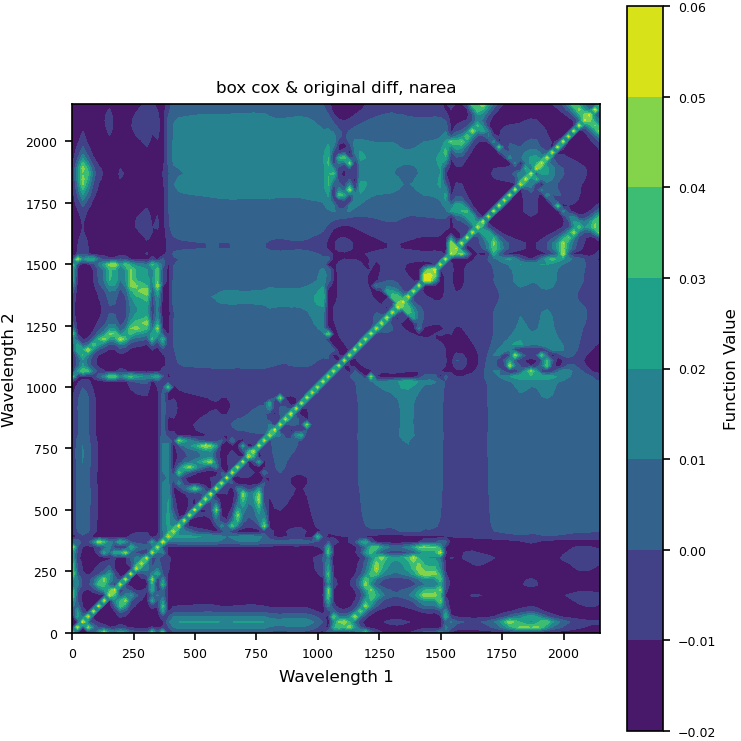

In [10]:
# Create a contour plot
plt. figure(figsize=(5,5))
plt.contourf(X1, X2, diff_Z.reshape(n, n), cmap='viridis')
cbar = plt.colorbar(label='Function Value')

# Add labels and title
plt.xlabel('Wavelength 1')
plt.ylabel('Wavelength 2')
plt.title("box cox & original diff, narea")

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')
cbar.ax.set_aspect(10, adjustable='box')
plt.show()

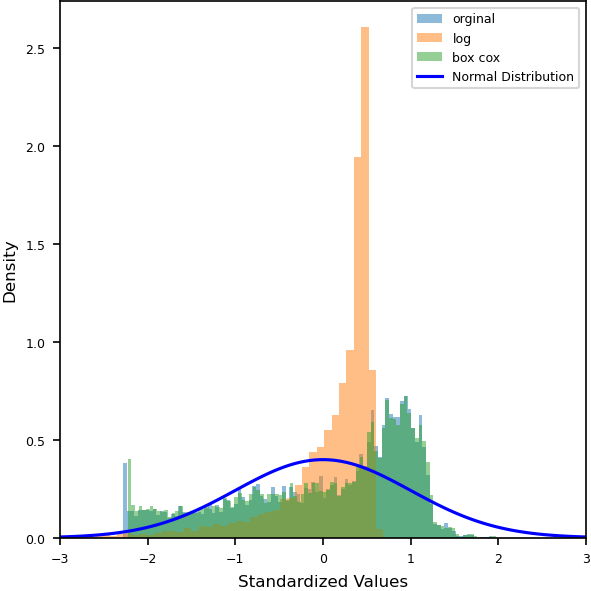

In [11]:
Z = lookup(X)
Z = cleanZeros(Z)

with plt.rc_context(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)):
    plt.figure(figsize=(4,4))
    Z_prob, Z_bin, _ = plt.hist(stadardize(Z.flatten()), bins=100, density=True, alpha=0.5, label="orginal")
    Zlog_prob, Zlog_bin, _ = plt.hist(stadardize(torch.log(Z.flatten())), bins=100, density=True, alpha=0.5, label="log")
    
    fitted_data, fitted_lambda = stats.boxcox(Z.flatten())
    Zlog_prob, Zlog_bin, _ = plt.hist(stadardize(fitted_data), bins=100, density=True, alpha=0.5, label="box cox")
    
    mu = 0  # mean
    sigma = 1  # standard deviation
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2 / (2*sigma**2))

    # Plot the normal curve
    plt.plot(x, y, label='Normal Distribution', color='blue')
    
    plt.xlim(-3,3)
    plt.legend()

    plt.xlabel('Standardized Values')
    plt.ylabel('Density')
    #plt.title('Histogram ')
    plt.show()


In [12]:
def kl_div(probabilities, bins):
    mean = 3
    std_dev = 1
    normal_probs = norm.pdf(bins, loc=mean, scale=std_dev)

    # Compute KL divergence
    kl_divergence = np.sum(probabilities * np.log(probabilities / normal_probs))
    return kl_divergence

0.9999994791224289 +- 3.885010748679589e-07
0.8501613999664368 +- 0.012655939924036174
0.9999942311231008 +- 7.806215490971719e-06
0.8333698922514529 +- 0.012906514690246252


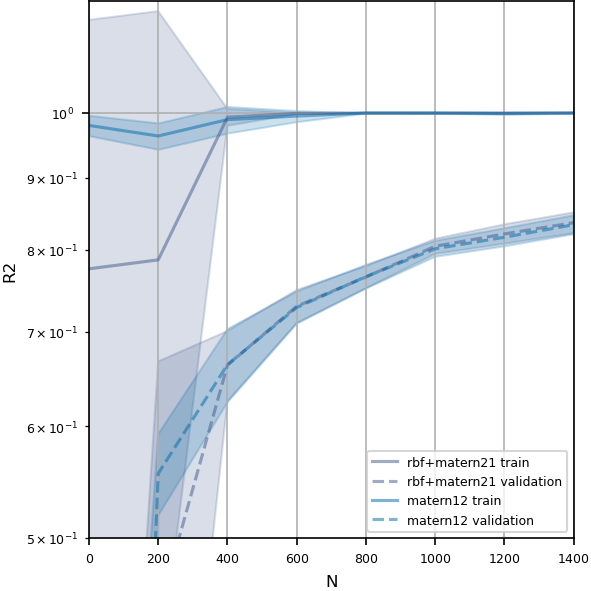

In [75]:
# Define color palette
#colors = ["green", "blue", "orange", "green"]
colors = tueplots.constants.color.palettes.tue_secondary

#files = ["matern12_prior_box_cox_narea", "matern12_prior_log_narea", "matern12_prior_standardize_narea"]
#run_name = ["boxcox", "log", "original"]

files = ["additive_large", "matern21_prior_large"]
run_name = ["rbf+matern21", "matern12"]

#files = ["matern12_narea", "matern32_narea", "matern52_narea", "rbf_narea"]#["20240418-170844"] #"gp_fit_log_narea" "gp_fit_boxcox_narea" ,"gp_fit_original_narea", 
#run_name = ["matern12", "matern32", "matern52", "rbf"]#["saas"] #boxcox", "original",

seeds = [0,1,2,3,4]
trait = "narea"

with plt.rc_context(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)):
    fig, ax = plt.subplots(1,1, figsize=(4,4))

    for idx, timestamp in enumerate(files):
        base_path = f"./output/{timestamp}"
        
        # Get data function
        def getCol(col_name):
            _results = [pd.read_csv(f"{base_path}/gp_{seed}.npy", encoding='utf-8')[col_name] for seed in seeds]
            _results = [np.array(_results[i]) for i in range(0,len(_results))]
            return _results

        n = getCol("n")[0]
        train_loss = getCol("train_loss")
        val_loss = getCol("val_loss")

        # Define linePlot function with linestyle parameter
        def linePlot(ax, _results, label, linestyle):
            mean, var = np.mean(_results, axis=0), np.std(_results, axis=0)
            print(mean[-1], "+-", var[-1])

            ax.plot(n, mean, label=label, linestyle=linestyle, alpha=0.5, color=colors[idx])
            ax.fill_between(n, mean - var,  mean + var, alpha=0.2, color=colors[idx])
            return

        linePlot(ax, train_loss, label=f"{run_name[idx]} train", linestyle='-')  # Solid line for training data
        linePlot(ax, val_loss, label=f"{run_name[idx]} validation", linestyle='--')  # Dashed line for validation data

        ax = ax
        ax.grid(True)
        #ax.set_title(f"gp fit") 
        ax.set_xlabel("N") 
        ax.set_ylabel("R2")
        ax.legend(loc="lower right")
        ax.set_yscale('log')
        ax.set_xlim(0,1400)
        ax.set_ylim(0.5, 1.2)

    plt.show()

3.3170010297345343e-06
-2.441364032934601e-06
0.2750963133649914
0.1702114210149417
0.272733058108297
0.1691152486307674
7.26166182740684e-08
-4.476974889477958e-06


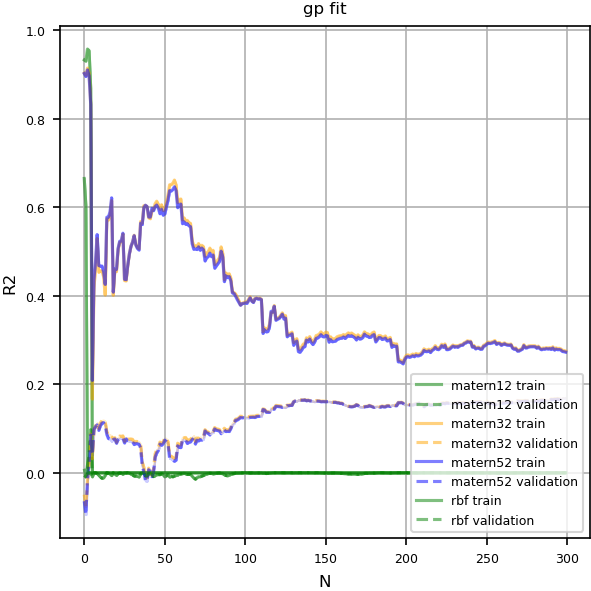

In [69]:
# Define color palette
colors = ["green", "orange", "blue", "green"]
#colors = tueplots.constants.color.palettes.tue_secondary

#files = ["20240411-160303", "20240411-160324", "20240411-160351"]
#run_name = ["boxcox", "log", "original"]

files = ["matern12_narea", "matern32_narea", "matern52_narea", "rbf_narea"]#["20240418-170844"] #"gp_fit_log_narea" "gp_fit_boxcox_narea" ,"gp_fit_original_narea", 
run_name = ["matern12", "matern32", "matern52", "rbf"]#["saas"] #boxcox", "original",

seeds = [0]#,1,2,3,4]
trait = "narea"

with plt.rc_context(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)):
    fig, ax = plt.subplots(1,1, figsize=(4,4))

    for idx, timestamp in enumerate(files):
        base_path = f"./output/{timestamp}"
        
        # Get data function
        def getCol(col_name):
            _results = [pd.read_csv(f"{base_path}/gp_{seed}.npy", encoding='utf-8')[col_name] for seed in seeds]
            _results = [np.array(_results[i]) for i in range(0,len(_results))]
            return _results

        n = getCol("n")[0]
        train_loss = getCol("train_loss")
        val_loss = getCol("val_loss")

        # Define linePlot function with linestyle parameter
        def linePlot(ax, _results, label, linestyle):
            mean, var = np.mean(_results, axis=0), np.std(_results, axis=0)
            ax.plot(n, mean, label=label, linestyle=linestyle, alpha=0.5, color=colors[idx])
            ax.fill_between(n, mean - var,  mean + var, alpha=0.2, color=colors[idx])
            return

        linePlot(ax, train_loss, label=f"{run_name[idx]} train", linestyle='-')  # Solid line for training data
        linePlot(ax, val_loss, label=f"{run_name[idx]} validation", linestyle='--')  # Dashed line for validation data

        ax = ax
        ax.grid(True)
        ax.set_title(f"gp fit") 
        ax.set_xlabel("N") 
        ax.set_ylabel("R2")
        ax.legend(loc="lower right")

    plt.show()

In [1]:
from data_util import getLookup

original = getLookup("narea")
standardize = getLookup("narea", "standardized")
box_cox = getLookup("narea", "box_cox")

here1
here1


In [3]:
original - box_cox

tensor([[-0.2935, -0.2935, -0.2935,  ...,  0.0756,  0.0751,  0.0752],
        [-0.2935, -0.2935, -0.0860,  ...,  0.0795,  0.0792,  0.0792],
        [-0.2935, -0.0807, -0.2935,  ...,  0.0777,  0.0773,  0.0773],
        ...,
        [ 0.0802,  0.0799,  0.0806,  ..., -0.2935, -0.2935, -0.2935],
        [ 0.0802,  0.0799,  0.0806,  ..., -0.2935, -0.2935, -0.1903],
        [ 0.0802,  0.0799,  0.0806,  ..., -0.2935, -0.1919, -0.2935]],
       dtype=torch.float64)